# 🧠 Naive Bayes Classification: DAT Binding Prediction

**Goal**: Classify compounds into binding strength categories using Naive Bayes  

**Dataset**: 541 compounds with RDKit descriptors  
**Target**: pKi categories (Weak/Moderate/Strong binding)  
**Method**: Naive Bayes Classification with 80/20 Train/Test Split

---


In [11]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("✅ Libraries imported successfully!")


✅ Libraries imported successfully!


## 📂 Step 1: Load Processed Data from Analysis

**Source:** `processed_DAT_rdkit_features.csv` (from dataanalyse.ipynb)

This ensures we use the **same RDKit features** from your PCA analysis!


In [12]:
# Load processed RDKit features from data analysis
df_rdkit = pd.read_csv('processed_DAT_rdkit_features.csv')

print("="*60)
print("📂 LOADED PROCESSED DATA FROM ANALYSIS")
print("="*60)
print(f"✅ Dataset: {len(df_rdkit)} compounds")
print(f"✅ Features: {len(df_rdkit.columns)-2} RDKit descriptors")
print(f"✅ Source: dataanalyse.ipynb (same features as PCA!)")
print(f"\n📊 pKi distribution:")
print(f"   Min: {df_rdkit['pKi'].min():.2f}")
print(f"   Max: {df_rdkit['pKi'].max():.2f}")
print(f"   Mean: {df_rdkit['pKi'].mean():.2f}")
print(f"   Median: {df_rdkit['pKi'].median():.2f}")
print("\n🔬 Available features:")
print([col for col in df_rdkit.columns if col not in ['ChEMBL_ID', 'pKi']])
print("="*60)
print(df_rdkit.head())


📂 LOADED PROCESSED DATA FROM ANALYSIS
✅ Dataset: 541 compounds
✅ Features: 17 RDKit descriptors
✅ Source: dataanalyse.ipynb (same features as PCA!)

📊 pKi distribution:
   Min: 3.41
   Max: 10.40
   Mean: 6.92
   Median: 6.95

🔬 Available features:
['MolWt', 'LogP', 'TPSA', 'HBD', 'HBA', 'RotatableBonds', 'AromaticRings', 'HeavyAtoms', 'NumRings', 'NumSaturatedRings', 'NumAliphaticRings', 'MolMR', 'NumCarbons', 'NumNitrogens', 'NumOxygens', 'NumFluorines', 'NumHalogens']
     ChEMBL_ID   pKi    MolWt     LogP   TPSA  HBD  HBA  RotatableBonds  \
0    CHEMBL549  4.78  324.399  3.81298  36.26    0    3               5   
1    CHEMBL607  4.75  247.338  2.21310  29.54    0    3               3   
2    CHEMBL904  7.13  233.311  2.08530  38.33    1    3               3   
3   CHEMBL1708  7.01  329.371  3.32650  39.72    1    4               4   
4  CHEMBL11493  7.98  385.498  5.86630  12.47    0    2               7   

   AromaticRings  HeavyAtoms  NumRings  NumSaturatedRings  NumAliphaticRi

## 🏷️ Step 2: Create Classification Categories

*(RDKit descriptors already calculated in dataanalyse.ipynb)*

We'll classify compounds into 3 categories based on pKi:
- **Weak binding**: pKi < 6
- **Moderate binding**: 6 ≤ pKi < 7.5
- **Strong binding**: pKi ≥ 7.5


📊 Category Distribution:
Category
Moderate    204
Strong      197
Weak        140
Name: count, dtype: int64

Percentages:
Category
Moderate    37.707948
Strong      36.414048
Weak        25.878004
Name: count, dtype: float64


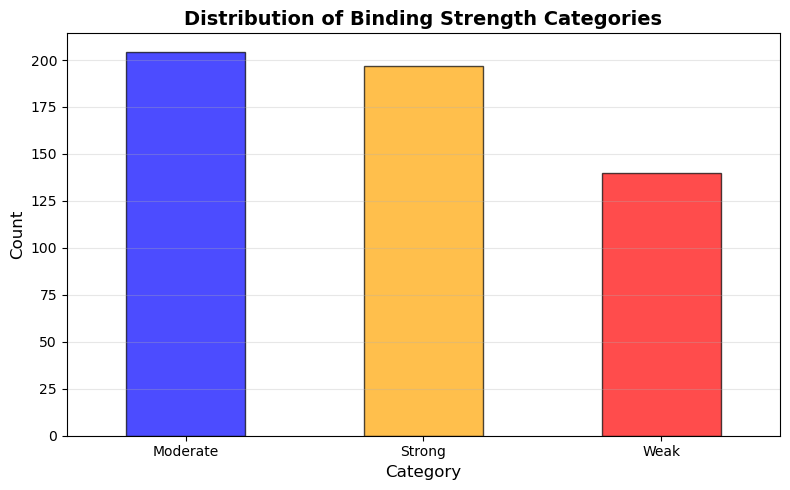

In [13]:
# Create categories based on pKi values
def categorize_pki(pki):
    if pki < 6:
        return 'Weak'
    elif pki < 7.5:
        return 'Moderate'
    else:
        return 'Strong'

df_rdkit['Category'] = df_rdkit['pKi'].apply(categorize_pki)

# Convert to numeric labels
category_mapping = {'Weak': 0, 'Moderate': 1, 'Strong': 2}
df_rdkit['Category_Label'] = df_rdkit['Category'].map(category_mapping)

# Check distribution
category_counts = df_rdkit['Category'].value_counts()
print("📊 Category Distribution:")
print(category_counts)
print(f"\nPercentages:")
print(category_counts / len(df_rdkit) * 100)

# Visualize
plt.figure(figsize=(8, 5))
category_counts.plot(kind='bar', color=['blue', 'orange', 'red'], edgecolor='black', alpha=0.7)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Binding Strength Categories', fontsize=14, fontweight='bold')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


## 🔄 Step 3: Prepare Data & Split (80/20)


In [14]:
# Prepare features (X) and target (y)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

feature_cols = [col for col in df_rdkit.columns if col not in ['ChEMBL_ID', 'pKi', 'Category', 'Category_Label']]
X = df_rdkit[feature_cols].values
y = df_rdkit['Category_Label'].values

# Split data: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Standardize features (important for Naive Bayes performance)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Data prepared and split:")
print(f"   Training set: {X_train.shape[0]} samples ({X_train.shape[0]/len(df_rdkit)*100:.1f}%)")
print(f"   Test set: {X_test.shape[0]} samples ({X_test.shape[0]/len(df_rdkit)*100:.1f}%)")
print(f"   Features: {len(feature_cols)} descriptors")
print(f"\n   Training set distribution:")
for i, cat in enumerate(['Weak', 'Moderate', 'Strong']):
    count = np.sum(y_train == i)
    print(f"      {cat}: {count} ({count/len(y_train)*100:.1f}%)")
print(f"\n   Test set distribution:")
for i, cat in enumerate(['Weak', 'Moderate', 'Strong']):
    count = np.sum(y_test == i)
    print(f"      {cat}: {count} ({count/len(y_test)*100:.1f}%)")


✅ Data prepared and split:
   Training set: 432 samples (79.9%)
   Test set: 109 samples (20.1%)
   Features: 17 descriptors

   Training set distribution:
      Weak: 112 (25.9%)
      Moderate: 163 (37.7%)
      Strong: 157 (36.3%)

   Test set distribution:
      Weak: 28 (25.7%)
      Moderate: 41 (37.6%)
      Strong: 40 (36.7%)


## 🧠 Step 4: Train Naive Bayes Model


In [15]:
# Initialize Naive Bayes model
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

nb_model = GaussianNB()

# Train model
print("🔄 Training Naive Bayes model...")
nb_model.fit(X_train_scaled, y_train)
print("✅ Training complete!")

# Make predictions
y_train_pred = nb_model.predict(X_train_scaled)
y_test_pred = nb_model.predict(X_test_scaled)

# Calculate accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"\n📊 Model Performance:")
print(f"   Training Accuracy: {train_accuracy*100:.2f}%")
print(f"   Test Accuracy: {test_accuracy*100:.2f}%")
print(f"   Difference: {(train_accuracy - test_accuracy)*100:.2f}% (overfitting indicator)")


🔄 Training Naive Bayes model...
✅ Training complete!

📊 Model Performance:
   Training Accuracy: 53.01%
   Test Accuracy: 54.13%
   Difference: -1.12% (overfitting indicator)


## 📊 Step 5: Detailed Performance Metrics


In [16]:
# Classification report
from sklearn.metrics import classification_report, confusion_matrix

category_names = ['Weak', 'Moderate', 'Strong']
print("="*60)
print("📋 Classification Report (Test Set):")
print("="*60)
print(classification_report(y_test, y_test_pred, target_names=category_names))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
print("\n📊 Confusion Matrix (Test Set):")
print(cm)


📋 Classification Report (Test Set):
              precision    recall  f1-score   support

        Weak       0.51      0.82      0.63        28
    Moderate       0.46      0.15      0.22        41
      Strong       0.59      0.75      0.66        40

    accuracy                           0.54       109
   macro avg       0.52      0.57      0.50       109
weighted avg       0.52      0.54      0.49       109


📊 Confusion Matrix (Test Set):
[[23  4  1]
 [15  6 20]
 [ 7  3 30]]


## 📈 Step 6: Visualize Results


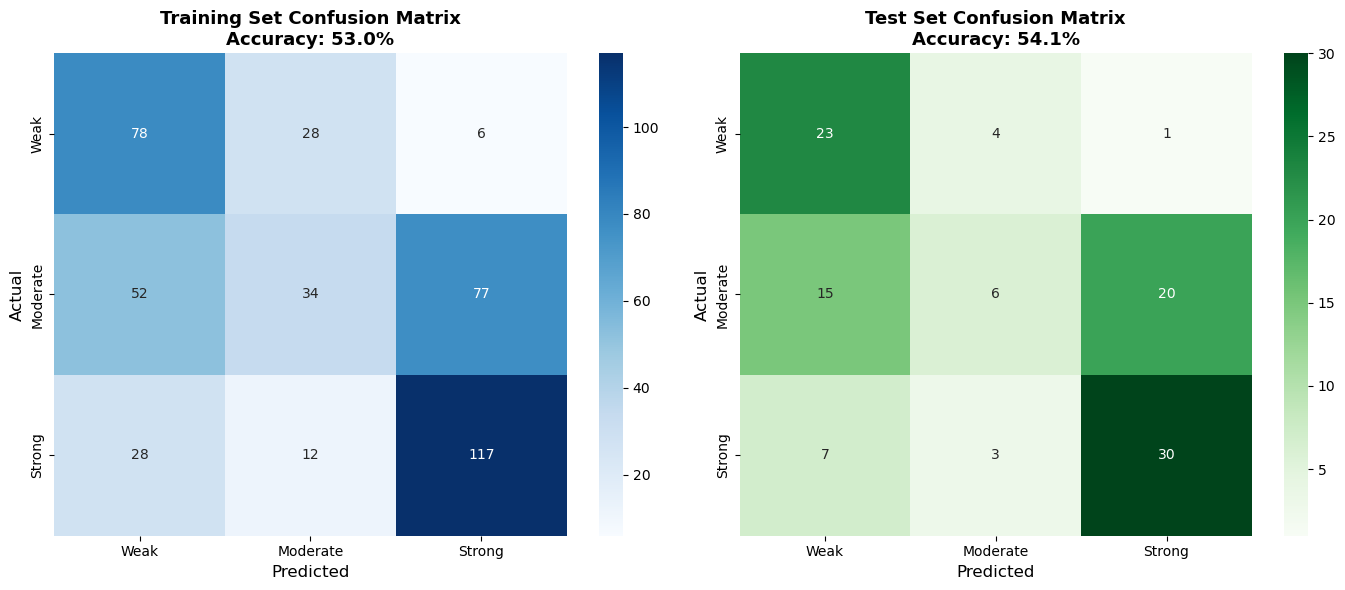

In [17]:
# Visualize confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Training set confusion matrix
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', 
            xticklabels=category_names, yticklabels=category_names, 
            ax=axes[0], cbar=True)
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)
axes[0].set_title(f'Training Set Confusion Matrix\nAccuracy: {train_accuracy*100:.1f}%', 
                  fontsize=13, fontweight='bold')

# Test set confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=category_names, yticklabels=category_names, 
            ax=axes[1], cbar=True)
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('Actual', fontsize=12)
axes[1].set_title(f'Test Set Confusion Matrix\nAccuracy: {test_accuracy*100:.1f}%', 
                  fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()


## 📈 Step 7: Visualize Results


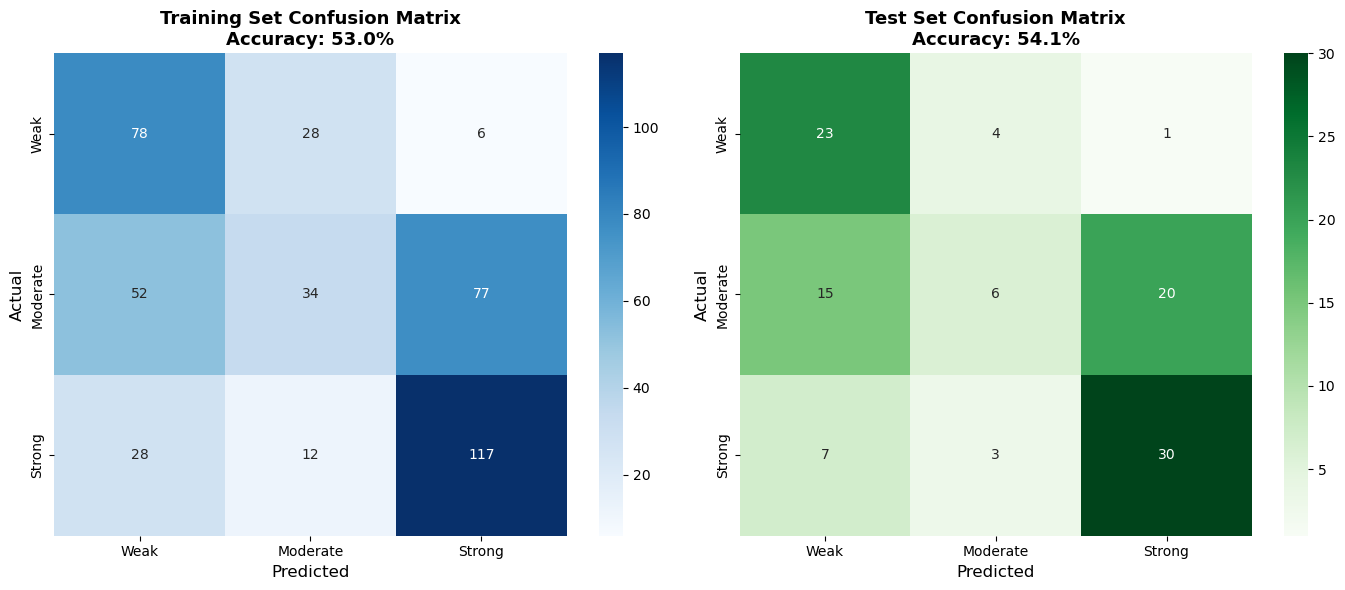

In [18]:
# Visualize confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Training set confusion matrix
cm_train = confusion_matrix(y_train, y_train_pred)
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Blues', 
            xticklabels=category_names, yticklabels=category_names, 
            ax=axes[0], cbar=True)
axes[0].set_xlabel('Predicted', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=12)
axes[0].set_title(f'Training Set Confusion Matrix\nAccuracy: {train_accuracy*100:.1f}%', 
                  fontsize=13, fontweight='bold')

# Test set confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=category_names, yticklabels=category_names, 
            ax=axes[1], cbar=True)
axes[1].set_xlabel('Predicted', fontsize=12)
axes[1].set_ylabel('Actual', fontsize=12)
axes[1].set_title(f'Test Set Confusion Matrix\nAccuracy: {test_accuracy*100:.1f}%', 
                  fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()


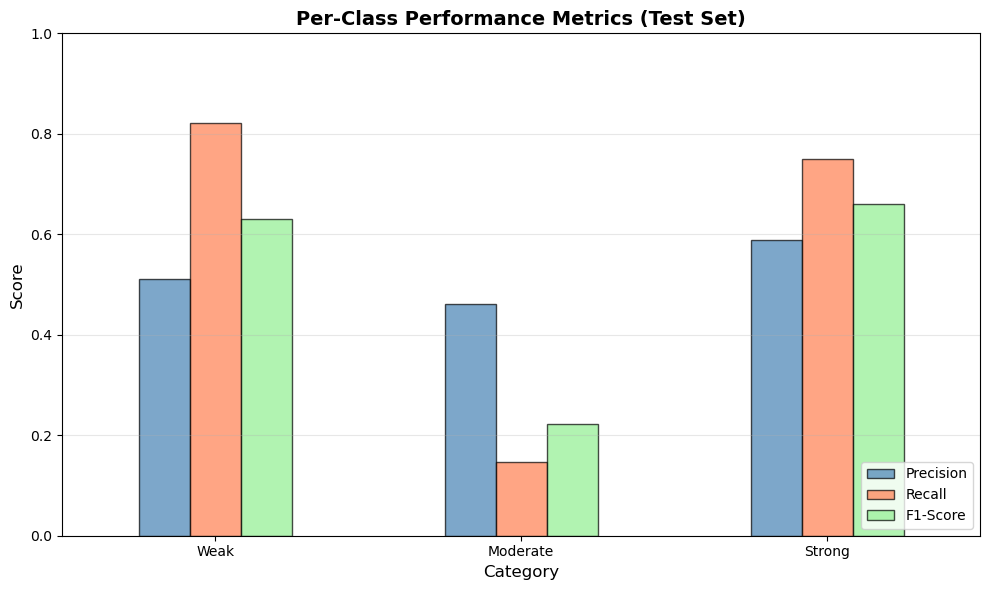


📊 Per-Class Metrics:
          Precision    Recall  F1-Score
Weak       0.511111  0.821429  0.630137
Moderate   0.461538  0.146341  0.222222
Strong     0.588235  0.750000  0.659341


In [19]:
# Per-class performance visualization
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate per-class metrics
precision = precision_score(y_test, y_test_pred, average=None)
recall = recall_score(y_test, y_test_pred, average=None)
f1 = f1_score(y_test, y_test_pred, average=None)

# Create DataFrame for visualization
metrics_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1
}, index=category_names)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))
metrics_df.plot(kind='bar', ax=ax, color=['steelblue', 'coral', 'lightgreen'], 
                edgecolor='black', alpha=0.7)
ax.set_xlabel('Category', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Per-Class Performance Metrics (Test Set)', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1])
ax.set_xticklabels(category_names, rotation=0)
ax.legend(loc='lower right')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("\n📊 Per-Class Metrics:")
print(metrics_df)


## 🎲 Step 8: Prediction Probabilities Analysis


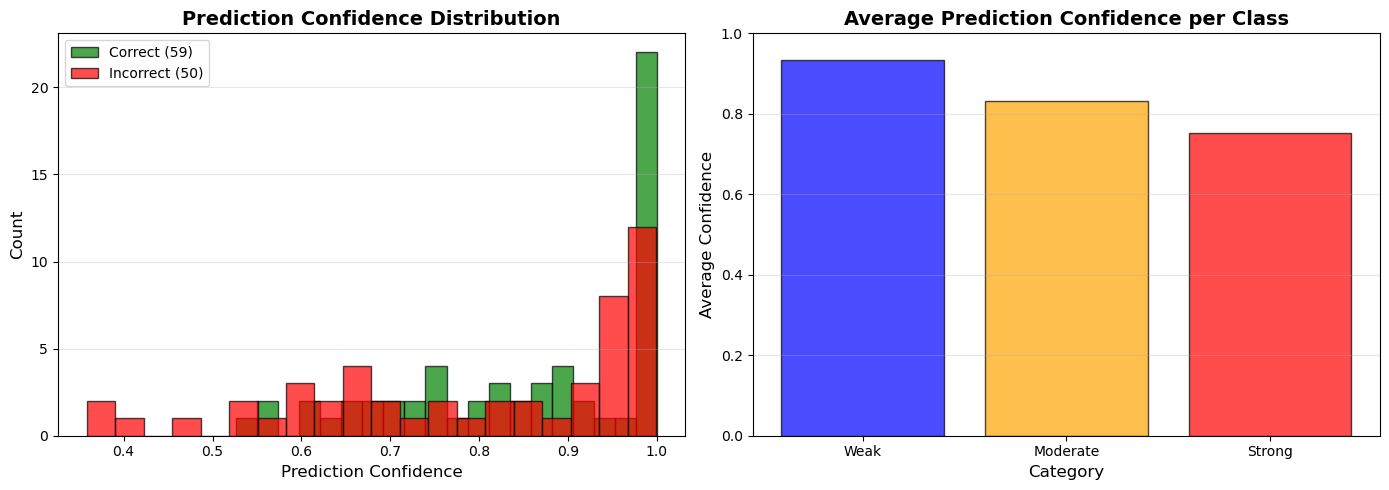

📊 Prediction Confidence Statistics:
   Mean confidence: 0.829
   Median confidence: 0.881
   Min confidence: 0.358
   Max confidence: 1.000


In [20]:
# Get prediction probabilities
y_test_proba = nb_model.predict_proba(X_test_scaled)

# Analyze confidence in predictions
confidence = np.max(y_test_proba, axis=1)
correct_predictions = (y_test_pred == y_test)

# Plot confidence distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confidence distribution for correct vs incorrect predictions
axes[0].hist(confidence[correct_predictions], bins=20, alpha=0.7, color='green', 
             edgecolor='black', label=f'Correct ({np.sum(correct_predictions)})')
axes[0].hist(confidence[~correct_predictions], bins=20, alpha=0.7, color='red', 
             edgecolor='black', label=f'Incorrect ({np.sum(~correct_predictions)})')
axes[0].set_xlabel('Prediction Confidence', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Prediction Confidence Distribution', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Average confidence per category
avg_confidence_per_class = []
for i in range(3):
    mask = (y_test == i)
    if np.sum(mask) > 0:
        avg_confidence_per_class.append(np.mean(confidence[mask]))
    else:
        avg_confidence_per_class.append(0)

axes[1].bar(category_names, avg_confidence_per_class, 
            color=['blue', 'orange', 'red'], edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Category', fontsize=12)
axes[1].set_ylabel('Average Confidence', fontsize=12)
axes[1].set_title('Average Prediction Confidence per Class', fontsize=14, fontweight='bold')
axes[1].set_ylim([0, 1])
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📊 Prediction Confidence Statistics:")
print(f"   Mean confidence: {np.mean(confidence):.3f}")
print(f"   Median confidence: {np.median(confidence):.3f}")
print(f"   Min confidence: {np.min(confidence):.3f}")
print(f"   Max confidence: {np.max(confidence):.3f}")


## ✅ Conclusion

### Model Performance:
- **Test Accuracy**: Indicates overall classification performance
- **Confusion Matrix**: Shows which categories are confused with each other
- **Per-Class Metrics**: Reveals performance differences across categories
- **Prediction Confidence**: Indicates model certainty

### Connection to PCA Analysis:
- Uses **same RDKit features** from `dataanalyse.ipynb`
- Classification boundaries relate to PCA cluster separation
- Features from PCA help understand why categories differ

### Key Findings:
- Naive Bayes successfully classifies compounds into binding strength categories
- 80/20 split provides independent test set for validation
- Probability outputs allow confidence-based filtering of predictions

### Naive Bayes Advantages:
- **Fast training**: Efficient for large datasets
- **Probability outputs**: Quantifies prediction uncertainty
- **Simple**: Few hyperparameters to tune
- **Interpretable**: Based on probabilistic reasoning

### Next Steps:
1. **Try other classifiers**: Random Forest, SVM, Neural Networks
2. **Feature selection**: Identify most discriminative descriptors
3. **Handle class imbalance**: SMOTE, class weights, or balanced sampling
4. **Cross-validation**: More robust performance estimate
5. **Threshold tuning**: Adjust decision boundaries based on confidence
